**15장 – RNN과 CNN을 사용해 시퀀스 처리하기**

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지와 텐서플로 버전이 2.0 이상인지 확인합니다.

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.
런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.


# 기본적인 RNN

RNN(recurrent neural networks) : 순환 신경망  
미래를 예측할 수 있다.(어느 정도 까지만)  
* RNN에 있는 두 가지 주요 난제
1. 불안정한 그레이디언트는 순환 드롭아웃과 순환 층 정규화를 포함한 여러 가지 기법을 사용해 감소시킬 수 있다.
1. 제한적인 단기 기억은 LSTM과 GRU 셀을 이용해 확장할 수 있다.

> 입력과 출력 시퀀스
1. 시퀀스 투 시퀀스 네트워크
1. 시퀀스 투 벡터 네트워크
1. 벡터 두 시퀀스 네트워크
1. 인코더-디코더

## 데이터셋 생성

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [3]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [4]:
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

> * 시계열은 일반적으로 [배치크기, 타임 스텝 수, 차원 수]이다.  
* 단변량 시계열은 dimensionality가 1이고, 다변량 시계열은 1이상이다.   
* x_train은 7000개의 시계열을 담고있고, 각 시계열마다 하나의 값을 예측해야 하기 때문에 타깃(y_train)은 열 벡터이다.

그림 저장 time_series_plot


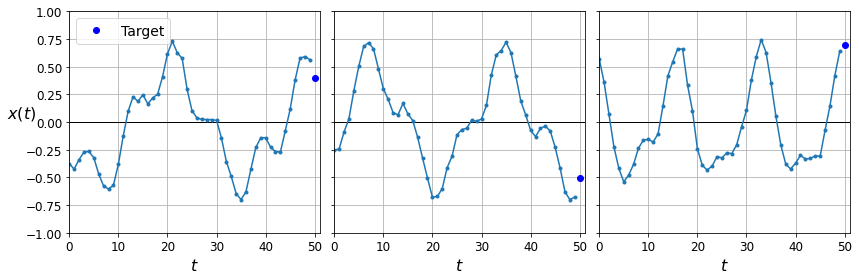

In [5]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
save_fig("time_series_plot")
plt.show()

**노트**: 이 노트북에서 파란 점은 타깃을 나타내고 빨강 X 표시는 예측을 나타냅니다. 처음에 책에서 파란 X 표시를 타깃에 사용하고 빨강 점을 예측에 사용했다가 나중에 바꾸었습니다. 혼동을 드려 죄송합니다.

## 기준 성능 계산하기

1. 단순한 예측 (마지막 관측값을 사용해 예측합니다):

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

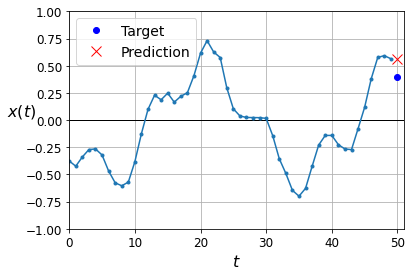

In [7]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

2. 선형 예측(완전 연결 네트워크 사용):  
* 입력마다 1차원 특성 배열을 기대하기 때문에 flatten 층을 추가해야 한다.

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [9]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0042


0.004168087150901556

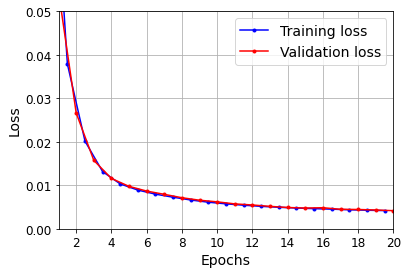

In [10]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 1ms/step


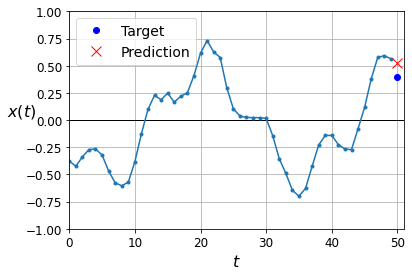

In [11]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 간단한 RNN 사용하기

> * 순환 신경망은 어떠한 길이의 타임 스텝도 처리할 수 있기에 입력 시퀀스의 길이를 지정할 필요 없다. => 첫 번째 입력차원 None
* 기본적으로 SimpleRNN 층은 하이퍼볼릭 탄젠트 활성화 함수 사용
* 초기 상태 h(init)를 0으로 설정하고 첫 번째 타임 스탭 x(0)와 함께 하나의 순환 뉴런으로 전달한다.
* 뉴런은 이 값의 가중치 합을 계산하고 하이퍼볼릭 탄젠트 활성화 함수를 적용하여 결과를 만들어 첫 번쨰 y0를 출력한다.
* 기본 RNN에서는 이 출력이 새로운 상태 h0가 된다.(이 새로운 상태는 다음 입력 값 x(1)과 함께 동일한 순환 뉴런으로 전달된다.)
* 이 과정이 마지막 타임 스텝까지 반복되어 마지막 값 y49를 출력한다. 
* 모든 시계열 과정에 대해 이 과정이 모두 '동시에' 수행된다.

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0116 - val_loss: 

> 0.0114에 달하는 MSE
* 순진한 예측보다는 낫지만 간단한 선형 모델을 앞지르지는 못한다.
* 선형 모델은 각 뉴런에 대해 입력(타임 스텝)마다 하나의 파라미터를 가지고 편향이 있다.(총 51개의 파라미터)
* 반면 기본 RNN의 순환 뉴런은 입력과 은닉 상태 차원마나 하나의 파라미터를 가지고 편향이 있다.(총 3개의 파라미터)

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0109


0.010881561785936356

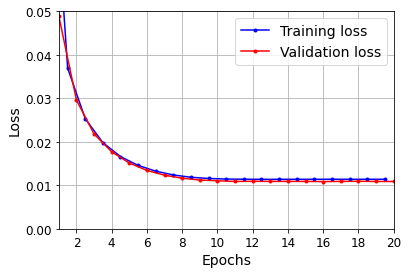

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

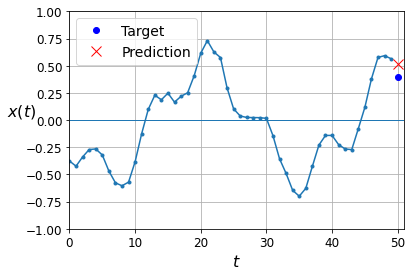

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 심층 RNN

> * 순환층을 쌓으면 심층 RNN이 된다.
* 밑의 예에서는 세 개의 SimpleRNN 층을 사용하지만, LSTM 층이나 GRU 층 같은 다른 종류의 순환 층을 추가할 수 있다.

In [14]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 9s 30ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 9s 40ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 9s 39ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 8s 39ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 8s 35ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0035 - val_l

> * 모든 순환 층에서 return sequenced = True로 설정해야 한다.(마지막 출력만 관심 대상이면 마지막 층에서는 설정하지 않는다.)
* 그렇지 않으면 모든 타임 스텝에 대한 출력을 담은 3D 배열이 아니라 마지막 타임 스텝의 출력만 담은 2D 배열이 출력되고 다음 순환 층이 3D 형태로 시퀀스를 받기 때문에 작동하지 못한다.

In [15]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0029


0.002910564886406064

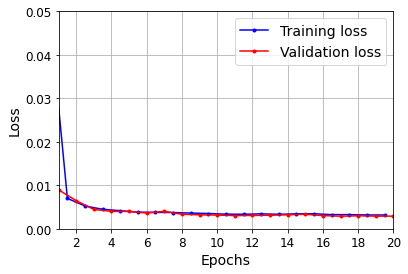

In [16]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 1s 8ms/step


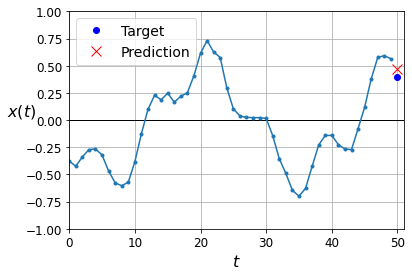

In [17]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

두 번째 `SimpleRNN` 층은 마지막 출력만 반환합니다:

> * 이 RNN은 한 타임 스텝에서 다음 타임 스텝으로 필요한 모든 정보를 나르기 위해 다른 순환 층의 은닉 상태를 주로 사용한다.
* 마지막 층의 은닉 상태는 크게 필요하지 않다. 또한 SimpleRNN층은 기본적으로 tanh 활성화 함수를 사용하기 때문에 예측된 값이 -1과 1 사이 범위에 놓인다.
* 따라서 출력층을 Dense 층으로 바꾸는 경우가 많다.(더 빠르면서도 정확도는 비슷)
* 이렇게 바꾸면 (이제는 마지막이 된) 두 번째 순환 층에서 return_sequences = True를 제거한다.

In [18]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),     ## return_sequences = True 제거
    keras.layers.Dense(1)       ## 출력층을 Dense 층으로 바꿈
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 23ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 7s 33ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0030 - val_lo

In [ ]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0026


0.002623623702675104

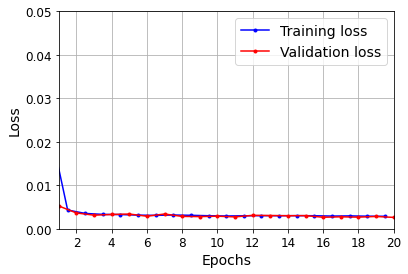

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

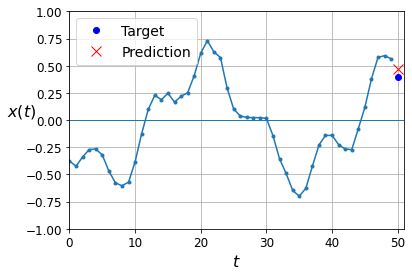

In [ ]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 여러 타임 스텝 앞을 예측하기

1. 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가하기(예측된 값이 실제로 발견된 것처럼 다룸)
> * 다음 스텝에 대한 예측은 보통 더 미래의 타임 스텝에 대한 예측보다 정확(미래의 타임 스텝은 오차가 누적될 수 있음)

In [19]:
np.random.seed(43) # 42는 훈련 세트에 있는 첫 번째 시리즈를 반환하기 때문에 다른 값으로 지정합니다

series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 38ms/step


In [21]:
# [배치크기, 타임스텝 수, 차원 수]
Y_pred.shape

(1, 10, 1)

그림 저장 forecast_ahead_plot


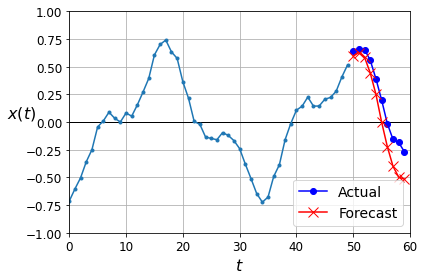

In [22]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

이 모델을 사용해 다음 10개의 값을 예측해 보겠습니다. 먼저 아홉 개의 타임 스텝을 더 가진 시퀀스를 다시 생성해야 합니다.

In [23]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

이제 하나씩 다음 10개의 값을 예측합니다:

In [24]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 7ms/step


In [25]:
Y_pred.shape

(2000, 10)

In [26]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510826

이 성능을 단순한 예측이나 간단한 선형 모델과 비교해 보죠:

In [27]:
## 단순한 방식 => 0.257 MSE(성능 매우 나쁨)
Y_naive_pred = np.tile(X_valid[:, -1], 10) # 마지막 타임 스텝 값을 선택해 10번 반복합니다
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.25697407

In [ ]:
## 간단한 선형 모델 => 0.0188 MSE(한 번에 하나의 미래 스텝 예측 위해 RNN 사용 하는 것 보다 낫다.)
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 743us/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 727us/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 731us/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 743us/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 721us/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 722us/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 731us/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 725us/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 735us/step - loss: 0.0228 

2. 동시에 다음 10개의 값을 모두 예측하는 RNN

> * 시퀀스-투-벡터 모델을 사용하지만 1개가 아니라 값 10개 출력

In [28]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)      ## 한 개의 유닛이 아니라 10개의 유닛을 가진 출력층 필요
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 21ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0110 - val_lo

In [29]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

1/1 [==============================] - 0s 265ms/step


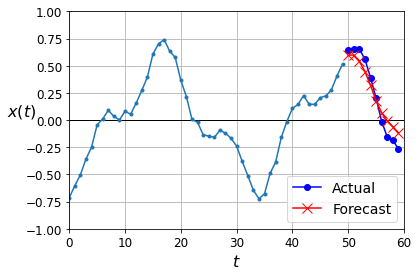

In [30]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

이제 타임 스텝마다 다음 10 스텝을 예측하는 RNN을 만들어 보겠습니다. 즉 타임 스텝 0에서 49까지를 기반으로 타임 스텝 50에서 59를 예측하는 것이 아니라, 타임 스텝 0에서 타임 스텝 1에서 10까지 예측하고 그다음 타임 스텝 1에서 타임 스텝 2에서 11까지 예측합니다. 마지막 타임 스텝에서는 타임 스텝 50에서 59까지 예측합니다. 이 모델은 인과 모델입니다. 어떤 타임 스텝에서 예측을 만들 때 과거 타임 스텝만 볼 수 있습니다.

> * 즉, 시퀀스-투-벡터 RNN을 시퀀스-투-시퀀스 RNN으로 바꿀 수 있다.
* 마지막 타임 스텝에서의 출력뿐만 아니라 모든 타임 스텝에서 RNN 출력에 대한 항이 손실에 포한된다는 것이다.
* 더 많은 오차 그레이디언트가 모델로 흐른다는 뜻이고 시간에 따라서만 흐를 필요가 없다.
* 각 타임 스텝의 출력에서 그레이디언트가 흐를 수 있다.
* 이는 훈련을 안정적으로 만들고 훈련 속도를 높인다.

In [31]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

> * 타깃이 입력에 포함된다.
* X_train과 Y_train은 중복이 많다 => 잘못 훈련하는 것이 아니라 타임 스텝마다 모델은 이전 타임 스텝만 볼 수 있고 앞을 볼 수 없다.(인과 모델)

In [32]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 27ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0367 - val_last_time_step_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0326 - last_time_step_mse: 0.0215 - val_loss: 0.0373 - val_last_time_step_mse: 0.0286
Epoch 4/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0300 - last_time_step_mse: 0.0190 - val_loss: 0.0273 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0276 - last_time_step_mse: 0.0158 - val_loss: 0.0259 - val_last_time_step_mse: 0.0135
Epoch 6/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0250 - last_time_step_mse: 0.0125 - val_loss: 0.0219 - val_last_time_step_mse: 0.0083
Epoch 7/20
219/219 [==

> * 스퀀스-투-시퀀스 모델로 바꾸려면 모든 순환 층에 return_sequences=True 지정해야 한다.(마지막 층에도)
* 그 다음 모든 타임 스텝에서 출력을 Dense 층에 적용한다.  

=> 이를 위해 TimeDistributed 층 제공(이 층은 다른층을 감싸서 입력 시퀀스의 모든 타임 스텝에 이를 적용함)
> * 각 타임 스텝을 별개의 샘플처럼 다루도록 입력의 크기를 바꾸어 이를 효과적으로 수행
* 즉, [배치크기, 타임 스텝 수, 입력 차원] => [배치크기*타임 스텝 수, 입력 차원]으로 바꾼다.

In [34]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
# 예측과 평가에는 마지막 타임 스텝의 출력만 사용됨

1/1 [==============================] - 0s 252ms/step


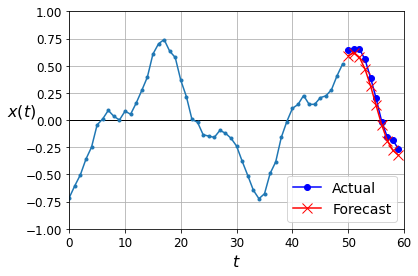

In [35]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# 배치 정규화를 사용한 심층 RNN

> * RNN과 효율적으로 사용할 수 없다.
* 배치 정규화가 은닉 상태가 아니라 입력에 적용했을 때만 조금 도움이 된다.(순환층 안이 아니라 순환층 사이에 적용했을 때 없는 것보다 조금 낫다.)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.BatchNormalization(),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.BatchNormalization(),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 13ms/step - loss: 0.4750 - last_time_step_mse: 0.5027 - val_loss: 0.0877 - val_last_time_step_mse: 0.0832
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0561 - last_time_step_mse: 0.0468 - val_loss: 0.0549 - val_last_time_step_mse: 0.0462
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0486 - last_time_step_mse: 0.0394 - val_loss: 0.0451 - val_last_time_step_mse: 0.0358
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0443 - last_time_step_mse: 0.0344 - val_loss: 0.0418 - val_last_time_step_mse: 0.0314
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0414 - last_time_step_mse: 0.0315 - val_loss: 0.0391 - val_last_time_step_mse: 0.0287
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0391 - last_time_step_mse: 0.0281 - val_loss: 0.0379 - val_last_time_step_mse: 0.0273
Epoch 7/20
219/219 [==

# 층 정규화를 사용한 심층 RNN

> * RNN에 잘 맞는 정규화이다.
* 배치 차원에 대해 정규화하는 대신 특성 차원에 대해 정규화 한다.
* 장점: 샘플에 독립적으로 타임 스텝마다 동적으로 필요한 통계 계산 가능 => 훈련과 테스트에서 동일한 방식으로 작동

In [36]:
from tensorflow.keras.layers import LayerNormalization

In [37]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [38]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 14s 46ms/step - loss: 0.1613 - last_time_step_mse: 0.1574 - val_loss: 0.0755 - val_last_time_step_mse: 0.0692
Epoch 2/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0665 - last_time_step_mse: 0.0575 - val_loss: 0.0597 - val_last_time_step_mse: 0.0484
Epoch 3/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0562 - last_time_step_mse: 0.0454 - val_loss: 0.0521 - val_last_time_step_mse: 0.0399
Epoch 4/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0498 - last_time_step_mse: 0.0378 - val_loss: 0.0466 - val_last_time_step_mse: 0.0337
Epoch 5/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0452 - last_time_step_mse: 0.0330 - val_loss: 0.0434 - val_last_time_step_mse: 0.0318
Epoch 6/20
219/219 [==============================] - 10s 45ms/step - loss: 0.0404 - last_time_step_mse: 0.0272 - val_loss: 0.0376 - val_last_time_step_mse: 0.0234
Epoch 7/20
219/2

# 사용자 정의 RNN 클래스 만들기

In [ ]:
class MyRNN(keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
        self.get_initial_state = getattr(
            self.cell, "get_initial_state", self.fallback_initial_state)
    def fallback_initial_state(self, inputs):
        batch_size = tf.shape(inputs)[0]
        return [tf.zeros([batch_size, self.cell.state_size], dtype=inputs.dtype)]
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size], dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        if self.return_sequences:
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    MyRNN(LNSimpleRNNCell(20), return_sequences=True,
          input_shape=[None, 1]),
    MyRNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 27ms/step - loss: 0.2860 - last_time_step_mse: 0.2822 - val_loss: 0.0734 - val_last_time_step_mse: 0.0624
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0679 - last_time_step_mse: 0.0546 - val_loss: 0.0566 - val_last_time_step_mse: 0.0423
Epoch 3/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0553 - last_time_step_mse: 0.0406 - val_loss: 0.0509 - val_last_time_step_mse: 0.0342
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0485 - last_time_step_mse: 0.0328 - val_loss: 0.0442 - val_last_time_step_mse: 0.0286
Epoch 5/20
219/219 [==============================] - 6s 25ms/step - loss: 0.0435 - last_time_step_mse: 0.0281 - val_loss: 0.0418 - val_last_time_step_mse: 0.0258
Epoch 6/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0404 - last_time_step_mse: 0.0249 - val_loss: 0.0382 - val_last_time_step_mse: 0.0229
Epoch 7/20
219/219 [==

# LSTM

> * 장단기 메모리 셀(long short-tern memory)
* 핵심 아이디어: 네트워크가 장기 상태에 저장할 것, 버릴 것, 읽어드릴 것 학습

> * 장기기억(C(t-1))은 네트워크를 왼쪽에서 오른쪽으로 관통하면서 ‘삭제 게이트’를 지나 일부 기억을 잃고, 그런 다음 덧셈 연산으로 새로운 기억 일부를 추가한다.(’입력 게이트’에서 선택한 기억 추가)
* 만들어진 C(t)는 다른 추가 변환 없이 바로 출력으로 보내진다. 그래서 타임 스텝마다 일부 기억이 삭제되고 일부 기억이 추가된다.
* 또한 덧셈 연산 후 이 장기상태가 복사되어 tanh 함수로 전달되어 출력 게이트에 의해 걸러진다. 이는 단기 상태 h(t)를 만든다.

LSTM 셀은 중요한 입력을 인식하고, 장기 상태에 저장하고 필요 기간동안 이를 보존하고, 필요할 때마다 이를 추출하기 위해 학습한다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 23ms/step - loss: 0.0979 - last_time_step_mse: 0.0877 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0515 - last_time_step_mse: 0.0326 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0407 - last_time_step_mse: 0.0196 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0356 - last_time_step_mse: 0.0156 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0330 - last_time_step_mse: 0.0138 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0313 - last_time_step_mse: 0.0124 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788681253790855, 0.00856079813092947]

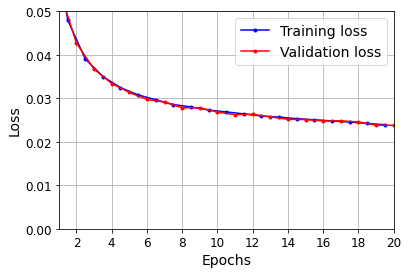

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

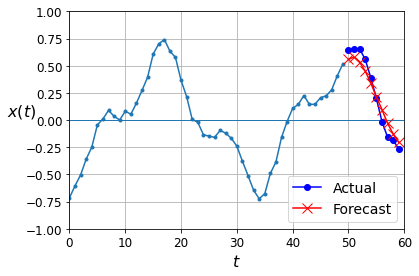

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

# GRU

> GRU셀은 LSTM 셀의 간소화된 버전이고 유사하게 작동하는 것 처럼 보인다.
* LSTM의 두 상태 벡터(장기기억, 단기기억)가 하나의 벡터 h(t)로 합쳐졌다.
* 하나의 게이트 제어기 z(t)가 삭제 게이트와 입력 게이트를 모두 제어한다.
* 출력 게이트가 없다. (전체 상태 벡터가 매 타임 스텝마다 출력된다.) 그러나 이전 상태의 어느 부분이 주 층(g(t))에 노출될지 제어하는 새로운 게이트 제어기 r(t)가 있다.

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 26ms/step - loss: 0.0995 - last_time_step_mse: 0.0940 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0495 - last_time_step_mse: 0.0383 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0432 - last_time_step_mse: 0.0321 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0379 - last_time_step_mse: 0.0261 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0333 - last_time_step_mse: 0.0192 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0310 - last_time_step_mse: 0.0158 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [ ]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262809693813324]

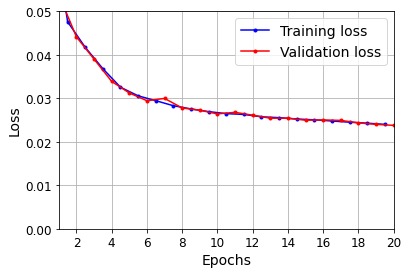

In [ ]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

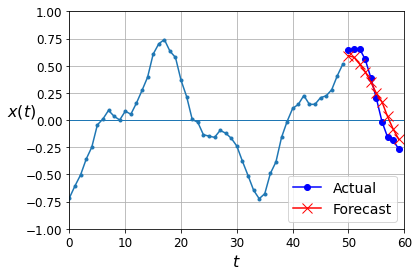

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

## 1D 합성곱 층을 사용해 시퀀스 처리하기

* LSTM, GRU 셀은 RNN 성공의 주역중 하나이다.
* 단순한 RNN보다 훨씬 긴 시퀀스를 다룰 수 있지만 매우 제한적인 단기 기억을 갖는다.
* 이 문제를 해결하는 한 가지 방법은 1D 합성곱 층을 사용해 입력 시퀀스를 짧게 줄이는 것


```
1D conv layer with kernel size 4, stride 2, VALID padding:

              |-----2-----|     |-----5---...------|     |-----23----|
        |-----1-----|     |-----4-----|   ...      |-----22----|
  |-----0----|      |-----3-----|     |---...|-----21----|
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 42 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 43 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 52 53 54 55 56 57 58 59

Output:

X:     0/3   2/5   4/7   6/9   8/11 10/13 .../43 42/45 44/47 46/49
Y:     4/13  6/15  8/17 10/19 12/21 14/23 .../53 46/55 48/57 50/59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 6s 16ms/step - loss: 0.0908 - last_time_step_mse: 0.0845 - val_loss: 0.0477 - val_last_time_step_mse: 0.0396
Epoch 2/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0437 - last_time_step_mse: 0.0357 - val_loss: 0.0367 - val_last_time_step_mse: 0.0285
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0356 - last_time_step_mse: 0.0282 - val_loss: 0.0307 - val_last_time_step_mse: 0.0218
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0293 - last_time_step_mse: 0.0201 - val_loss: 0.0259 - val_last_time_step_mse: 0.0152
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0256 - last_time_step_mse: 0.0152 - val_loss: 0.0246 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0239 - last_time_step_mse: 0.0129 - val_loss: 0.0227 - val_last_time_step_mse: 0.0115
Epoch 7/20
219/219 [==

## WaveNet

> 이 네트워크는 층마다 (각 뉴런의 입력이 떨어져 있는 간격인) 팽창 비율을 두 배로 늘리는 1D 합성곱 층을 쌓는다. 
* 첫 번째 합성곱 층이 한 번에 2개의 타임 스텝만 바라본다. 그 다음층은 4개의 타임 스텝을 보고(수용장의 길이가 4개인 타임 스텝이 되는 것), 그 다음은 8개의 타임 스텝을 보는 식이다.
* 이런 식으로 하위 층은 단기 패턴을 학습하고 상위 층은 장기 패턴을 학습한다. 팽창 비율을 2배로 늘린 덕분에 네트워크는 아주 긴 시퀀스를 매우 효율적으로 처리할 수 있다.

```
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\.../\ /\ /\ /\ /\ /\
   \  /  \  /  \  /  \  /  \  /  \  /  \       /  \  /  \  /  \
     /    \      /    \      /    \                 /    \
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /.../\ /\ /\ /\ /\ /\ /\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 43 44 45 46 47 48 49
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 44 45 46 47 48 49 50
  /10 11 12 13 14 15 16 17 18 19 20 21 22 ... 53 54 55 56 57 58 59
```

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0981 - last_time_step_mse: 0.0891 - val_loss: 0.0365 - val_last_time_step_mse: 0.0231
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0340 - last_time_step_mse: 0.0212 - val_loss: 0.0294 - val_last_time_step_mse: 0.0166
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0291 - last_time_step_mse: 0.0163 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0265 - last_time_step_mse: 0.0141 - val_loss: 0.0254 - val_last_time_step_mse: 0.0130
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0251 - last_time_step_mse: 0.0129 - val_loss: 0.0244 - val_last_time_step_mse: 0.0122
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0242 - last_time_step_mse: 0.0121 - val_loss: 0.0233 - val_last_time_step_mse: 0.0108
Epoch 7/20
219/219 [========

다음은 논문에 정의된 원본 WaveNet입니다: ReLU 대신에 GatedActivationUnit과 스킵 연결을 사용합니다. 또한 점점 더 시퀀스가 짧아지는 것을 피하기 위해 왼쪽에 0으로 패딩합니다:

In [ ]:
class GatedActivationUnit(keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [ ]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return keras.layers.Add()([z, inputs]), z

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

n_layers_per_block = 3 # 10 in the paper
n_blocks = 1 # 3 in the paper
n_filters = 32 # 128 in the paper
n_outputs = 10 # 256 in the paper

inputs = keras.layers.Input(shape=[None, 1])
z = keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)
z = keras.activations.relu(keras.layers.Add()(skip_to_last))
z = keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_proba = keras.layers.Conv1D(n_outputs, kernel_size=1, activation="softmax")(z)

model = keras.models.Model(inputs=[inputs], outputs=[Y_proba])

In [ ]:
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=2,
                    validation_data=(X_valid, Y_valid))

Epoch 1/2
219/219 [==============================] - 3s 9ms/step - loss: 0.1387 - last_time_step_mse: 0.1347 - val_loss: 0.1229 - val_last_time_step_mse: 0.1199
Epoch 2/2
219/219 [==============================] - 2s 8ms/step - loss: 0.1222 - last_time_step_mse: 0.1161 - val_loss: 0.1217 - val_last_time_step_mse: 0.1189


이 장에서 RNN의 기초 사항을 살펴 보았고 RNN을 사용해 시퀀스(소위 시계열)을 처리했습니다. CNN을 포함하여 시퀀스를 처리하는 다른 방법도 알아 보았습니다. 다음 장에서는 RNN을 자연어 처리에 적용해 보겠습니다. 그리고 RNN에 대해 더 자세히 배워 보겠습니다(양방향 RNN, 상태가 있는 RNN과 상태가 없는 RNN, 인코더-디코더, 어텐션을 사용한 인코더-디코더). 또한 어텐션만 사용하는 구조인 트랜스포머도 살펴 보겠습니다.